# Thermal angular spectrum of a molecule of BINOL
This notebook contains the codes for computing the absorption cross-section, and thermal angular spectrum of a single BINOL molecule. Here have been used two hdf5 files containing T-matrices for the BINOL-R molecule for a wavelength range between 190 nm and 10 $\mu$m. These T-matrices were computed for $j=1$, so that they are $6\times 6$ matrices


Last time edited: 08.04.2025

## Necessary libraries:
- Numpy for vector functions, as well for general math functions
- Matplotlib for plotting
- Treams to compute T-matrices
- Scipy for computing the singular value decomposition and for computing numerical integrals
- H5py for manipulating the T-matrix data

For T-matrices, the notebook is set by default for the helicity basis. More information in https://tfp-photonics.github.io/treams/treams.html# 

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import numpy.linalg as lg
import treams as trm
from scipy.optimize import linear_sum_assignment
from scipy import integrate
import matplotlib.colors as colors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Physical constants

In [3]:
hbar = 1.05457182e-34 #Dirac's constant in Js
Kb = 1.380649e-23 #Boltzmann's constant in J/K
c0 = 299792458 #Speed of light in vaccuum in m/s

## Importing the T-matrix data 

In [2]:
f1 = h5py.File('BINOL_B3LYP_def2-TZVP_chloroform_opt_escf_T_matrix_2024_06_26.hdf5', 'r') 
f2 = h5py.File('BINOL_B3LYP_def2-TZVP_chloroform_opt_vcd_escf_only_TDDFT_T_matrix_2025_02_19.hdf5' , 'r')

In [4]:
list(f1.keys())

['computation',
 'embedding',
 'lambda0',
 'materials',
 'modes',
 'object',
 'tmatrix']

In [5]:
wl1 = f1['lambda0'][...]
wl2 = f2['lambda0'][...]
TM1 = f1['tmatrix'][...]
TM2 = f2['tmatrix'][...]
l = f1['modes/l'][...]
m = f1['modes/m'][...]
pol = f1['modes/polarization'][...]
epsamb = float(f1['materials/embedding/relative_permittivity'][...])

print(pol)

[b'electric' b'electric' b'electric' b'magnetic' b'magnetic' b'magnetic']


In [6]:
Tmatrix = TM1+TM2

In [7]:
lvals = wl1[...] #Range of wavelengths in nm
fvals = c0*1e9/lvals #Range of frequencies in Hz
kvals = 2*np.pi*fvals/c0 #Range of k-vectos
kplot = 1e7/lvals #Range of wavenumbers (defined as 1/lambda) in 1/cm

## Converting the T-matrices to the helicity basis
The T-matrices from the `.h5` file were computed in the parity basis. Since we are interested in computing the emission spectrum depending on the helicity of the emitted photons, it is necessary to transform the T-matrices to the helicty basis. To do so, we use the function `changepoltype()` from the library treams. More information can be found in https://tfp-photonics.github.io/treams/params.html#polarizations

In [8]:
p = [ 1 if str(pol, encoding='utf8') == 'electric' else 0 for pol in pol]

i = [0,3,1,4,2,5]
Tmatrix = Tmatrix[:,i,:]
Tmatrix = Tmatrix[:,:,i]
basis = trm.SphericalWaveBasis.default(1)


Tt = [ trm.TMatrix(Tmatrix[i,...], k0=2*np.pi/wl1[i], material=epsamb, basis=basis, poltype='parity') for i in range(len(wl1))]

# Parity to helicity basis
Th = [ T.changepoltype() for T in Tt ]
Th = np.array(Th)

In [9]:
file = open('kplotvals_molecule.dat', 'w')
for k in range(len(kplot)):
    file.write('%.10e\n'%kplot[k])
    
file.close()

***

## Functions for calculating the T and S matrices and SVD
- The function `QmatrixFromT` computes the Q-matrix given a T-matrix. This matrix is given by $$\mathbf{Q} = -2\mathbf{T}-2\mathbf{T}^\dagger-4\mathbf{T}\mathbf{T}^\dagger,$$ as in Eq. (4). This function gives a matrix of the same size as the T-matrix.
- The function `SVD` computes the singular value decomposition of any Q-matrix in the array `Qmatrixarray`. The function returns an array with two elements: the first one is an matrix whose rows contain the singular values for a single frequency. The second element is matrix whose rows contain the singular vectors for each single frequency. More information can be read below on how to access to the singular values and vectors. 
***


In [10]:
def QmatrixFromT(Tmatrix):
    return -2*Tmatrix.T.conjugate() - 2*Tmatrix - 4*np.matmul(Tmatrix.T.conjugate(), Tmatrix)

#Computing a Q-atrix for each T-matrix in the array Tmatrix
Qmatrix = [QmatrixFromT(i) for i in Th] 


def SVD(Qmatrix):
    K, gamma, G = lg.svd(Qmatrix[0])
    val1, vec1 = gamma, G
    sorted_levels = [val1]
    sorted_vecs = [vec1]
        
    for Q in Qmatrix[1:]:
        K, gamma, G = lg.svd(Q)
        val2, vec2 = gamma, G
        ov_matrix = np.abs(vec1 @ vec2.T.conj())
        optimal = linear_sum_assignment(-ov_matrix)[1]
        sorted_levels.append(val2[optimal])
        vec1 = vec2[optimal,:]
        sorted_vecs.append(vec1)
    return [sorted_levels, sorted_vecs]

Here we compute the SVD of every matrix in `Qmatrix`. To get the n-th singular value of the $f$-th frequency value in `fvals`, one should use `vals[f][n]`. Analogously for the n-th singular vector of the $f$-th frequency value in `fvals`, i.e., `vecs[f][n]`.

In [11]:
#Here we compute the SVD
vals, vecs = SVD(Qmatrix)

## Planck energy density and the helicity-dependent absorption cross-section
Here I compute the absorption cross-section descriminated by the helicity of the absorbed photons, as given by Eq. (19), namely:
$$\sigma_\lambda(k) = \frac{\pi}{2k^2}\sum_s q_s(k)^2 \sum_{jm}|s_{jm\lambda}(k)|^2.$$
This is computed by the function `absxsec` which receives the array of k-vectors `kvals` and the helicity of the absorbed photons `lam`.

The function `PlanckE` computes the Planck energy density for a given k-vector `k` and temperature `T` , given by $$u(k, T) = \frac{\hbar c k^3}{\pi^2\left(e^{\hbar c k/k_B T} - 1 \right)}.$$

In [12]:
def absxsec(kvals, lam):
    sigma = []
    for k in range(len(kvals)):
        sums = 0
        for s in range(len(vals[0])):
            sumjm = 0
            for count in range(len(basis)):
                j, m, la = basis[count][1:]
                if la == lam:
                    sumjm += vecs[k][s][count]*np.conjugate(vecs[k][s][count])
            sums += vals[k][s]*sumjm
        sigma.append(np.pi*np.real(sums)/(2*kvals[k]**2))
    return np.array(sigma)

def PlanckE(k, T):
    return hbar*c0*(k**3)/(np.pi**2 * (np.exp(k*hbar*c0/(Kb*T)) - 1))

In [13]:
sigmaplus = absxsec(kvals, 1) 
print("Done")
sigmaminus = absxsec(kvals, 0)
print("Done")

Energy = PlanckE(kvals,300) #Energy density for a thermal bath at T = 300 K

Done
Done


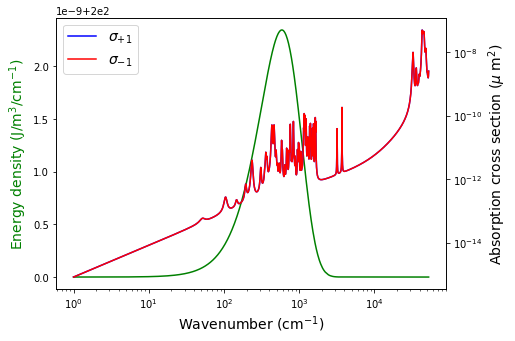

In [22]:
fig, ax1 = plt.subplots(figsize = (7,5))
ax2 = ax1.twinx()
ax2.loglog(kplot, 1e12*sigmaplus, c = 'blue', label = r"$\sigma_{+1}$")
ax2.loglog(kplot, 1e12*sigmaminus, c = 'red', label = r"$\sigma_{-1}$")
ax1.plot(kplot, 100*2*np.pi**Energy, c = 'green')
ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize = 14)
ax2.set_ylabel(r'Absorption cross section ($\mu$ m$^2)$', c = 'k', fontsize = 14)
ax1.set_ylabel('Energy density (J/m$^3$/cm$^{-1}$)', c= 'green',fontsize = 14)
ax2.legend(fontsize=14)
plt.show()


In [23]:
# Here we save the data for Fig 3a
file = open('DataFig3a.dat', "w")

for i in range(len(kplot)):
    file.write("%.6f\t%10.10e\t%.10e\t%10.10e\n"%(kplot[i], 1e12*sigmaplus[i], 1e12*sigmaminus[i],200*np.pi*Energy[i]))
file.close()
        

***
## Functions for computing the emitssion thermal spectrum
- `PW2SW` is the function that transforms a vector from the plane wave basis to the multipolar basis. It takes as arguments the polar angle `theta` and azimuthal angle `phi`, the helicity of the emitted radiation `lam`, and the maximum multipolar order `jmax`. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value 1 is necessary. The function `SphericalWaveBasis.default(jmax)` provides the values of $j$ , $m$ and $\lambda$ for each element of the array given the value of `jmax`, which is necessary to know the corresponding values to transform. Since states with opposite polarization are orthogonal, only elements with the same polarization as the one of interest (`lam`) are converted. The function returns a vector with the coefficients, whose dimension is $2j_\text{max}(j_\text{max} + 2).$
- The function `prodDs` calculates the product between the elements of the Wigner matrices $D^j_{m\lambda}$ and the vectors $|s\rangle$ (Eq. (11)). The function takes as parameters the vector of coefficients in the multipolar basis obtained from the PW2SW function, and a singular vector s. Since the library Treams handles helicity values of 0 for -1 helicity, conversion to the value -1 is necessary. The function returns the squared scalar product value between the vectors $D$ and $|s\rangle$.
- The function `KirchhoffsLaw` computes the thermal angular spectrum (Eq. (18)). This function uses the coefficients given by `PW2SW` by considering the direction $-\vec{k}$. This function takes as arguments the angles `theta` and `phi`, the helicity `lam` of the emitted radiation, the singular values `vals` and vectors `vecs`, respectively, the temperature `T`, and the maximum multipolar order `jmax`, and returns the value of the angular thermal spectrum multiplied by `k`, for having the correct units of photon density.
***

In [24]:
def PW2SW(theta, phi, lam):
    coeff = []
    indices = trm.SphericalWaveBasis.default(1)
    for count in range(len(indices)):
        j, m, la = indices[count][1:]
        if la == 0:
            la = -1
        if lam != la:
            coeff.append(0.0)
        else: 
            coeff.append(np.sqrt((2*j+1)/(4*np.pi))*trm.special.cython_special.wignerd(j,m,la,phi,theta,0))
    return coeff

def prodDs(Dvec, vec, lam):
    indices = trm.SphericalWaveBasis.default(1)
    summ = 0
    for count in range(len(indices)): #Loop over all possible combinacions of j,m and λ
        j, m, la = indices[count][1:]
        if la == 0:
            la = -1
        if la == lam:
            summ += np.conjugate(Dvec[count])*vec[count]
    return abs(summ)**2

def KirchhoffsLaw(theta, phi, lam, kvals, vals, vecs, T):
    beta = (hbar*c0)/(Kb*T)
    if lam == 0:
        lam = -1
    Dvec = PW2SW(np.pi-theta, phi + np.pi, lam) #Coefficients of the plane wave in spherical basis
    Expvals = []
    for f in range(len(kvals)): #loop over the frequencies
        Expval = 0
        for i in range(len(vals[0])): #loop over the modes
            Expval += c0*vals[f][i]/(2*np.pi*kvals[f]*(np.exp(beta*kvals[f]) -1)) * prodDs(Dvec, vecs[f][i], lam)
        Expvals.append(Expval)
    return kvals*Expvals

## Functions for computing the thermal spectrum as a function of $\theta$ or $\phi$
The functions FunPolar and FunPhi compute the thermal angular spectrum (Eq. (18)) as a function of `theta` and `phi`, respectively. These functions receive an array as a variable (either `theta_range` for having the spectrum as a function of $\theta$ or `phi_range` for having it as a function of $\phi$), the value of `jmax`, the temperature `T` and the arrays of singunar values `vals` and vectors `vecs`, and return a matrix whose dimensions are `len(phi_range)`$\times$ `len(fvals)`, or `len(theta_range)`$\times$ `len(fvals)`.

In [26]:
def FunPolar(theta_range, phi, lam, T, kvals, vals, vecs):
    aspec_angle = []
    for th in theta_range: #loop over all angles in theta_range
        aspec_angle.append(KirchhoffsLaw(th, phi, lam, kvals, vals, vecs, T))
    return aspec_angle

def FunPhi(theta, phi_range, lam, T, kvals,vals, vecs):
    aspec_angle = []
    for p in phi_range: #loop over all angles in phi_range
        aspec_angle.append(KirchhoffsLaw(theta, p, lam, kvals, vals, vecs, T))
    return aspec_angle    

In [27]:
theta_range = np.linspace(0.001, np.pi, 180)  #Array of values for theta

#Computing thermal angular spectrum as function of θ with the monochromatic theory for ϕ = π/4 and λ = 1
ph_densmono1_polar_pi4 = FunPolar(theta_range, np.pi/4, 1, 300, kvals, vals, vecs)
#Computing thermal angular spectrum as function of θ with the monochromatic theory for ϕ = π/4 and λ = -1
ph_densmono0_polar_pi4 = FunPolar(theta_range, np.pi/4, 0, 300, kvals, vals, vecs)

In [28]:
ph1_polar_pi4 = np.array(ph_densmono1_polar_pi4)
ph0_polar_pi4 = np.array(ph_densmono0_polar_pi4)

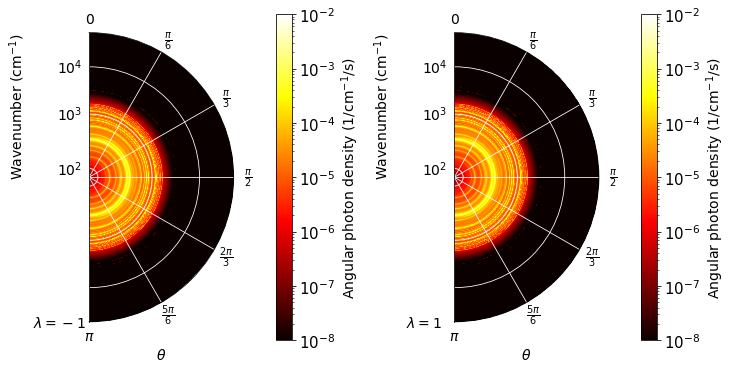

In [57]:
R, Theta = np.meshgrid(kplot, theta_range)

plt.figure(figsize=(12,6))
ax = plt.subplot(121, polar = True)
c = ax.pcolormesh(Theta, R, 200*np.pi*ph0_polar_pi4, cmap = 'hot', norm=colors.LogNorm(vmin = 1e-8, vmax=1e-2))
cbar = plt.colorbar(c, pad = -0.1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'Angular photon density (1/cm$^{-1}$/s)', size=14)
ax.tick_params(axis ='y', labelsize=14)
ax.tick_params(axis ='x', labelsize=14)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetamax(180)
ax.set_rscale('symlog', linthresh = 6e2)
#ax.set_rlim(rmin=6e2)
ax.set_yticks([1e2, 1e3, 1e4])
ax.set_yticklabels((r'$10^2$', r'$10^3$', r'$10^4$'))
ax.grid(True, c = 'white')
ax.set_xticks(np.linspace(0, 7*np.pi/6, 7, endpoint=False))
ax.set_xticklabels(['0', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\frac{5\pi}{6}$', r'$\pi$'])
ax.set_ylabel(r'Wavenumber (cm$^{-1}$)',labelpad = -10, fontsize = 14, loc = 'top')
ax.set_xlabel(r'$\theta$', fontsize = 14)
ax.text(3.5, 1.1e5, r'$\lambda = -1$', fontsize=14, color='k', ha='left')

ax = plt.subplot(122, polar = True)
c = ax.pcolormesh(Theta, R, 200*np.pi*ph1_polar_pi4, cmap = 'hot', norm=colors.LogNorm(vmin = 1e-8, vmax=1e-2))
cbar = plt.colorbar(c, pad = -0.1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'Angular photon density (1/cm$^{-1}$/s)', size=14)
ax.tick_params(axis ='y', labelsize=14)
ax.tick_params(axis ='x', labelsize=14)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetamax(180)
ax.set_rscale('symlog', linthresh = 6e2)
#ax.set_rlim(rmin=6e2)
ax.set_yticks([1e2, 1e3, 1e4])
ax.set_yticklabels((r'$10^2$', r'$10^3$', r'$10^4$'))
ax.grid(True, c = 'white')
ax.set_xticks(np.linspace(0, 7*np.pi/6, 7, endpoint=False))
ax.set_xticklabels(['0', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\frac{5\pi}{6}$', r'$\pi$'])
ax.set_ylabel(r'Wavenumber (cm$^{-1}$)',labelpad = -10, fontsize = 14, loc = 'top')
ax.set_xlabel(r'$\theta$', fontsize = 14)
ax.text(3.45, 1e5, r'$\lambda = 1$', fontsize=14, color='k', ha='left')

plt.show()

***
## Computing integral of the emission sprectrum over the solid angle

Now, we´re interested in computing the integral of the thermal emission spectrum over the solid angle, as defined in Eq. (20).

The function `IntegralSA` receives the value of `jmax`, the helicity of the emitted photons `lam`, the aaray of wavevectors `kvals`, the arrays of singular values and vectors `vals`and `vecs`, respectively, and the temperature `T`of the thermal bath. The integral is given by
$$ \mathcal{I}_\lambda(k) = \int_0^{2\pi} d\phi_k \int_0^{\pi} d\theta_k  \sin\theta_k \, k\, \mathbb{E}\{ |\langle \mathbf{k}\lambda|\Phi_\text{thermal}\rangle|^2\}.$$
This function returns an array of length `len(kvals)` which contains the integral over the solid angle for every wave vector in `kvals`.

***


In [34]:
def IntegralSA(lam, kvals, vals, vecs, T):
    beta = (hbar*c0)/(Kb*T)
    if lam == 0:
        lam = -1
        
    integral = []
        
    def Integrand(f, theta, phi):
        Dvec = PW2SW(np.pi-theta, phi + np.pi, lam)  #Coefficients of the plane wave in spherical basis
        Expval = 0 
        for i in range(len(vals[0])):
            Expval += c0*vals[f][i]/(2*np.pi*kvals[f]*(np.exp(beta*kvals[f]) -1)) * prodDs(Dvec, vecs[f][i], lam)
        return np.sin(theta)*Expval*kvals[f]
    
    for k in range(len(kvals)):
        # Performing numerical integration
        fint = lambda theta, phi: Integrand(k, theta, phi) #Defining the function to integrate
        integral.append(integrate.dblquad(fint, 0, 2*np.pi, 0, np.pi)[0]) #Double quadrature
    return integral        

In [36]:
# Here we compute the integral for both values of helicity
photonslam1 = IntegralSA(1, kvals, vals, vecs, 300) # λ = 1
print('Done')
photonslam0= IntegralSA(-1, kvals, vals, vecs, 300) # λ = -1
print('Done')

Done
Done


In [37]:
photonslam1 = np.array(photonslam1)
photonslam0 = np.array(photonslam0)

# Here we compute the thermal g-factor as defined in Eq. (22)
gfac = 2*(photonslam1-photonslam0)/(photonslam1+photonslam0)

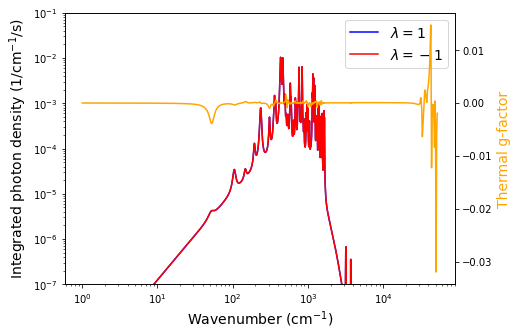

In [45]:
fig, ax1 = plt.subplots(figsize = (7,5))
ax2 = ax1.twinx()
ax1.loglog(kplot, 200*np.pi*photonslam1, c = 'blue', label = r'$\lambda = 1$')
ax1.loglog(kplot, 200*np.pi*photonslam0, c = 'red', label = r'$\lambda = -1$')
ax1.set_ylabel(r'Integrated photon density (1/cm$^{-1}$/s)', fontsize = 14)
ax1.set_ylim(1e-7,1e-1)
ax2.plot(kplot, gfac, c = 'orange')
ax2.set_ylabel(r'Thermal g-factor', fontsize = 14, c = 'orange')
ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)', fontsize = 14)
ax1.legend(fontsize = 14)
plt.show()

*** 
The total number of emitted photons of helicity $\lambda$ per second is given by Eq. (21), namely
$$ N_\lambda = \int dk \, \mathcal{I}_\lambda(k).$$.
This is computed in the following cell by using the function `trapz`from Numpy.
***

In [46]:
int0 = np.trapz(photonslam0, kvals)
int1 = np.trapz(photonslam1, kvals)
print('Emitted photons for helicity λ = -1: ', int0)
print('Emitted photons for helicity λ = 1: ', int1)

Emitted photons for helicity λ = -1:  1.1159867390611518
Emitted photons for helicity λ = 1:  1.1160012129692962


In [48]:
# Here we save the data for Fig 3b
file = open('DataFig3b.dat','w')

for i in range(len(kplot)):
    file.write('%.5f\t%.10e\t%.10e\n'%(kplot[i], 200*np.pi*photonslam1[i], 200*np.pi*photonslam0[i]))
    
file.close()